In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import trimesh
import pytest
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from b3d.bayes3d.image_likelihoods import gaussian_iid_pix_likelihood_vec, threedp3_gmm_likelihood_vec, kray_likelihood_intermediate_vec



In [2]:
## L2 distance test 

PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

In [3]:
## posterior grows as object is moved into distance

In [4]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

h,w,fx,fy,cx,cy = 50, 50, 100.0, 100.0, 25.0, 25.0
renderers = [
    b3d.RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
    for scale in [9]
]

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [5]:
cam_y_distance = 0.8

linear_pose_from_points = lambda points1, points2, alpha: b3d.Pose.from_position_and_target(
    jnp.array([0.0, -cam_y_distance, 0.1]),
    jnp.zeros(3)
).inv() @ b3d.Pose.from_translation((1 - alpha) * points1 + alpha * points2 )



def render_rgbd_many(renderer, vertices, faces, attributes):
    return renderer.render_many(
        vertices,
        faces,
        jnp.concatenate([attributes, vertices[...,-1:]],axis=-1)
    )


In [6]:

# gaussian iid args
gaussian_iid_pix_likelihood_args = {'rgb_tolerance': 50.0,
                   'depth_tolerance': 0.05,
                   'outlier_prob': 0.01}

# GMM args
threedp3_gmm_likelihood_args = {'variance': 2.0,
                   'outlier_prob': 0.1,
                   'outlier_volume': 10**3,
                   'filter_size': 3,
                   'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}

# ray-tracing likelihood args
kray_likelihood_args = {'color_tolerance': 50.0, #100
                    'depth_tolerance': 0.005, #0.005
                    'inlier_score': 5.0,
                    'outlier_prob': 0.005,
                    'multiplier': 1.0, # 10000.0
                    'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}





In [7]:
# gaussian iid args
gaussian_iid_pix_likelihood_args = {'rgb_tolerance': 50.0,
                   'depth_tolerance': 0.025,
                   'outlier_prob': 0.01}

# GMM args
threedp3_gmm_likelihood_args = {'variance': 0.1,
                   'outlier_prob': 0.1,
                   'outlier_volume': 10**3,
                   'filter_size': 3,
                   'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}

# ray-tracing likelihood args
kray_likelihood_args = {'color_tolerance': 50.0,
                    'depth_tolerance': 0.01,
                    'inlier_score': 25, #2.5,
                    'outlier_prob': 0.005,
                    'multiplier': 10.0,
                    'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}


In [8]:
distances = jnp.linspace(0,1.5,4) - 0.3

gt_images = []

models = [gaussian_iid_pix_likelihood_vec, threedp3_gmm_likelihood_vec, kray_likelihood_intermediate_vec]
model_names = ['i.i.d Normal', '3DP3 GMM', 'Surface-ray']
model_args = [gaussian_iid_pix_likelihood_args, threedp3_gmm_likelihood_args, kray_likelihood_args]
num_points = 4001
model_scores = []
dist_min, dist_max = -0.1, 0.1

for model_ind, model in enumerate(models):
    model_scores_distances = []
    for distance in distances:
        point1 = jnp.array([dist_min,distance,0])
        point2 = jnp.array([dist_max,distance,0])

        # 0.1 is horizontal range

        alphas = jnp.linspace(0, 1, num_points)
        vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

        linear_poses = vec_fun(point1, point2, alphas)

        split_poses = linear_poses.split(10)
        logpdfs = []

        rgbd_im = render_rgbd_many(renderers[0], jnp.array([linear_poses[len(linear_poses)//2].apply(object_library.vertices)]), 
                                   object_library.faces, jnp.tile(object_library.attributes, (1,1,1)))

        gt_image = rgbd_im[0,...,:3]
        gt_images.append(gt_image)
        
        gt_image_depth = np.array(rgbd_im[0,...,3])
        gt_image_depth[gt_image_depth==0] = 10.0
        gt_image_depth = jnp.array(gt_image_depth)
        observed_image  =  jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1)

        for split_pose in split_poses:
            pose_distances = split_pose.pos[:,0]
            transformed_vertices = jax.vmap(lambda i: split_pose[i].apply(object_library.vertices))(jnp.arange(len(split_pose)))

            N = len(split_pose)

            rendered_imgs = render_rgbd_many(renderers[0], transformed_vertices, object_library.faces, jnp.tile(object_library.attributes, (N,1,1)))

            logpdfs.append(model(observed_image, rendered_imgs,  model_args[model_ind])[0])
        logpdfs = jnp.concatenate(logpdfs)
        model_scores_distances.append(logpdfs)
    model_scores.append(model_scores_distances)

<Figure size 640x480 with 0 Axes>

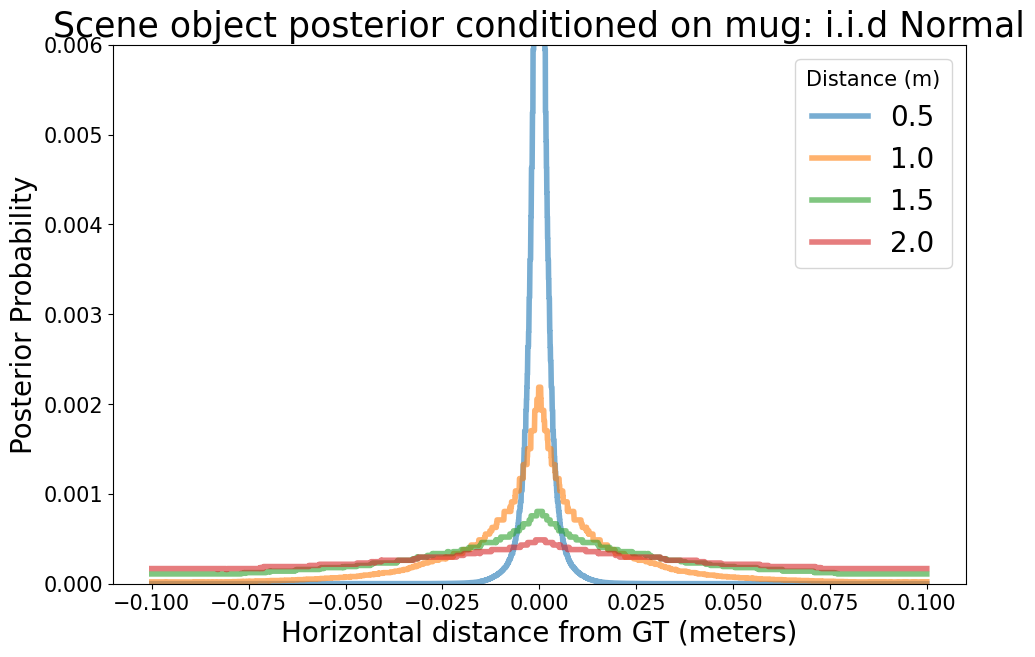

<Figure size 640x480 with 0 Axes>

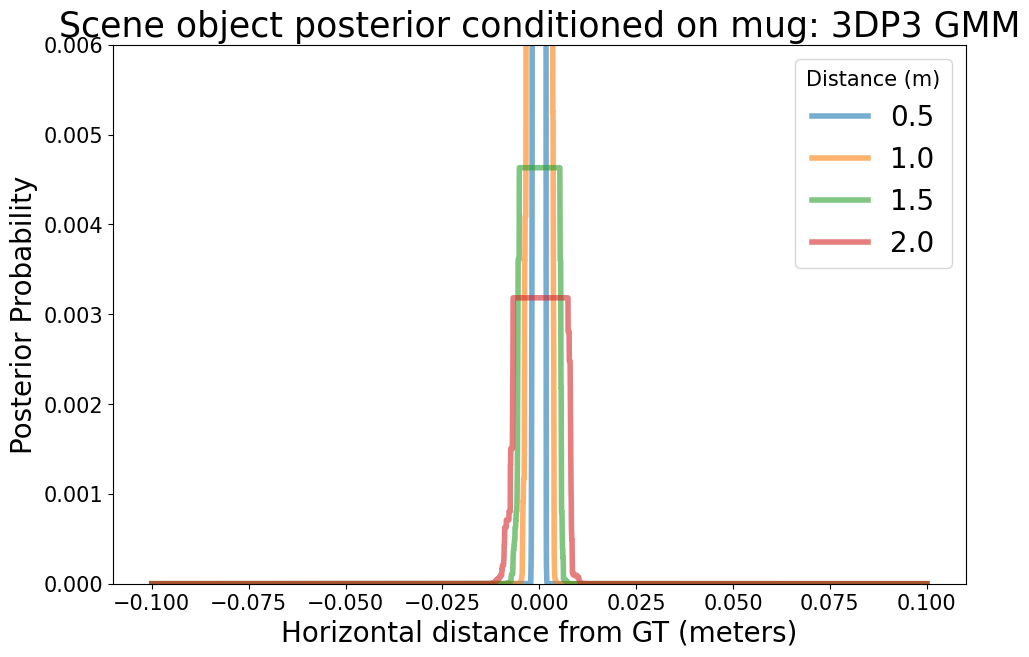

<Figure size 640x480 with 0 Axes>

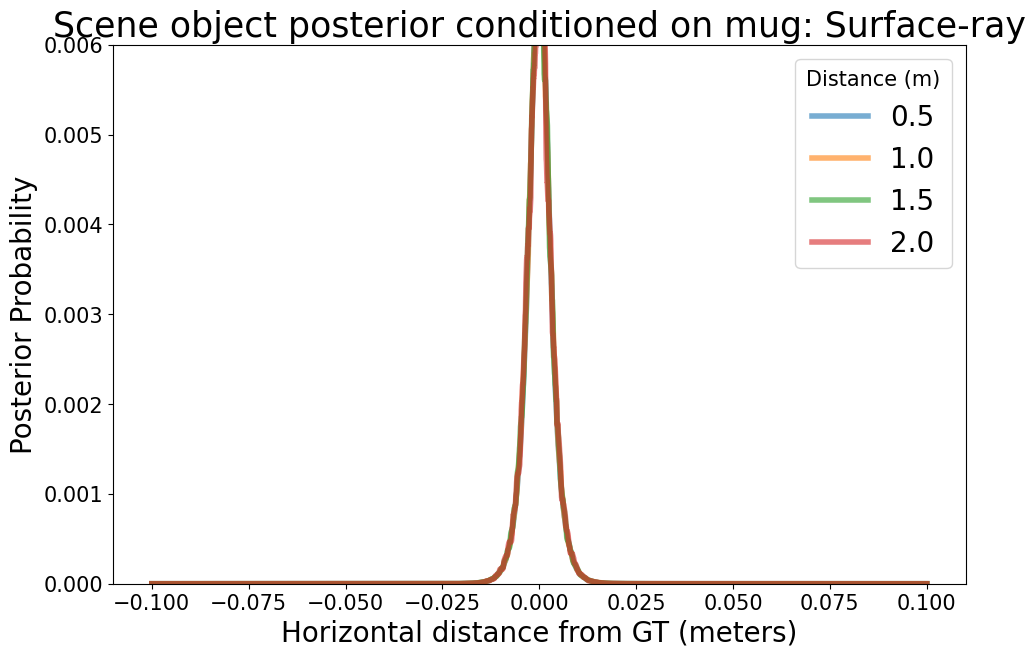

In [9]:
# plotting 
model_scores = jnp.array(model_scores)
for model_ind, model in enumerate(models):
    plt.figure()
    fig, axes = plt.subplots(1, 1, figsize=(11, 7))
    num_ticks = 3
    for dist_ind, distance in enumerate(distances):
        axes.plot(jnp.linspace(dist_min, dist_max, num_points), b3d.normalize_log_scores(model_scores[model_ind, dist_ind]), alpha=0.6, linewidth=4, label=str(distance + cam_y_distance))
    title = "Scene object posterior conditioned on mug: " + model_names[model_ind]
    plt.title(title, fontsize=25)
    legend=plt.legend(fontsize=20, title="Distance (m)")
    legend.get_title().set_fontsize('15')
    axes.tick_params(axis='x', labelsize=15)
    axes.tick_params(axis='y', labelsize=15)
    axes.set_ylim(0.0, 0.006)
    plt.xlabel("Horizontal distance from GT (meters)", fontsize=20)
    plt.ylabel("Posterior Probability", fontsize=20)

In [10]:
num_points = 4001
distance = 0.25
observed_images = []
scale = 9
renderer = b3d.RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
distances = jnp.linspace(0,1.5,4) - 0.3

for d_ind, distance in enumerate(distances):
    gt_pose = b3d.Pose.from_position_and_target(jnp.array([0.0, -0.8, 0.1]), jnp.zeros(3)).inv() @ b3d.Pose.from_translation(jnp.array([0,distance,0]))
    transformed_vertices = gt_pose.apply(object_library.vertices)[None,...]
    images = render_rgbd_many(renderer,transformed_vertices,object_library.faces, jnp.tile(object_library.attributes, (1,1,1)))
    gt_image = images[0,...,:3]
    gt_image_depth = np.array(images[0,...,3])
    gt_image_depth[gt_image_depth==0] = 10.0
    gt_image_depth = jnp.array(gt_image_depth)
    observed_images.append(jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1))

vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

<Figure size 640x480 with 0 Axes>

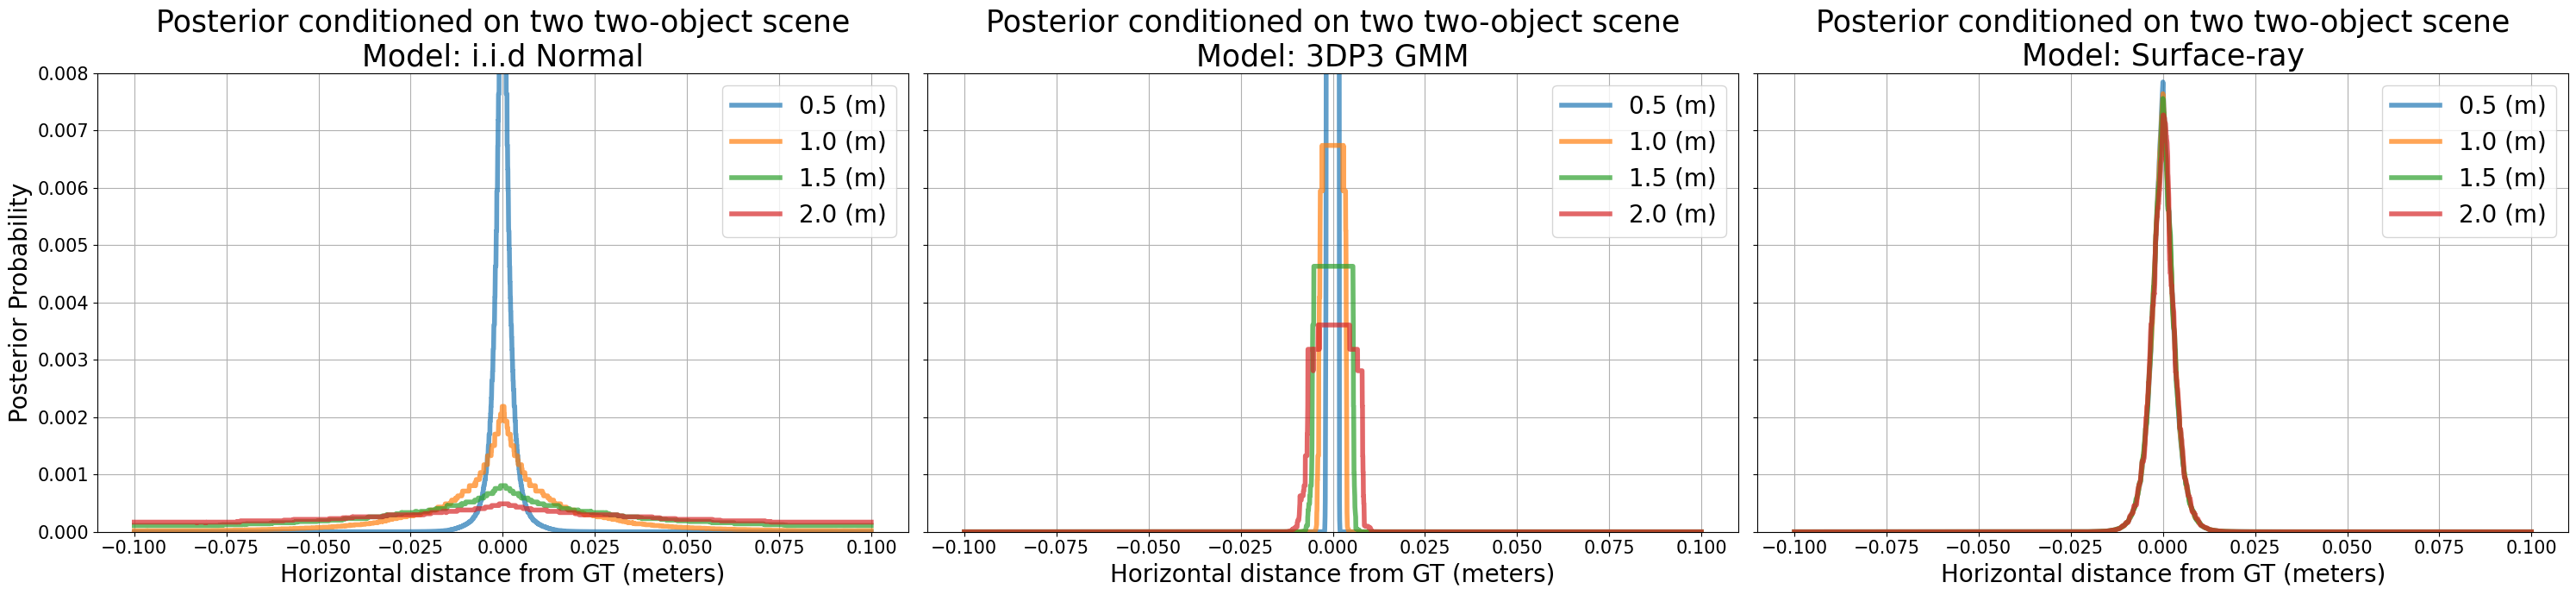

In [13]:
# sweep y from -0.25 to 1.5
plt.figure()
fig, axes = plt.subplots(1, len(models), figsize=(10*len(models), 7))
for model_ind, model in enumerate(models):
    ax = axes[model_ind]
    for d_ind, distance in enumerate(distances):
        horizontal_range = 0.1
        point1 = jnp.array([-horizontal_range,distance,0])
        point2 = jnp.array([horizontal_range,distance,0])
        alphas = jnp.linspace(0, 1, num_points)
        linear_poses_batches = vec_fun(point1, point2, alphas).split(10)
        logpdfs = []
        translations = []
        for linear_poses in linear_poses_batches:
            transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))
            rendered_imgs = render_rgbd_many(renderer,transformed_vertices,object_library.faces, jnp.tile(object_library.attributes, (len(linear_poses),1,1)))
            logpdfs.append(model(observed_images[d_ind], rendered_imgs,  model_args[model_ind])[0])
            translations.append(linear_poses.pos[:,0])
        logpdfs = jnp.concatenate(logpdfs)
        translations = jnp.concatenate(translations)
        ax.plot(translations, b3d.normalize_log_scores(logpdfs), alpha=0.7, linewidth=4, label=str(distance + cam_y_distance)+' (m)')
    title = "Posterior conditioned on two two-object scene\nModel: " + str(model_names[model_ind])
    ax.set_title(title, fontsize=25)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.legend(fontsize=20)
    ax.set_xlabel("Horizontal distance from GT (meters)", fontsize=20)
    ax.grid(True)
    if model_ind == 0:
        ax.set_ylabel("Posterior Probability", fontsize=20)
    else:
        ax.yaxis.set_ticklabels([])
    ax.set_ylim(0.0, 0.008)
fig.tight_layout()

In [14]:
# drawing posterior samples

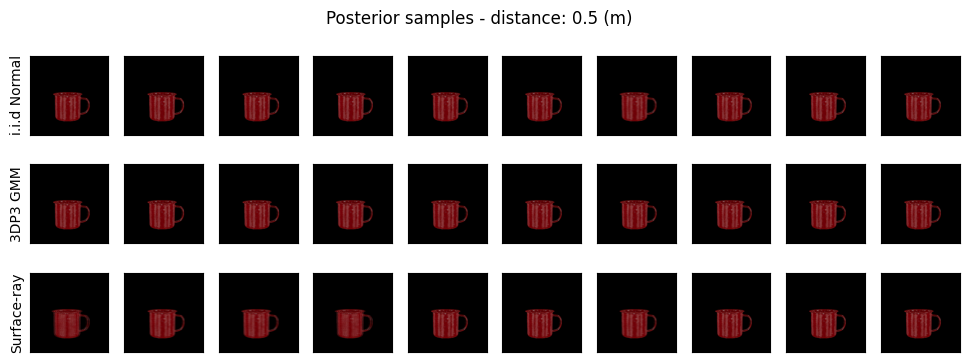

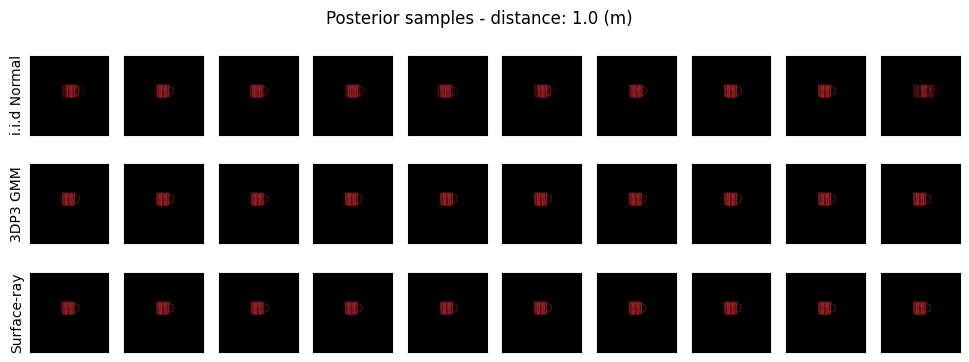

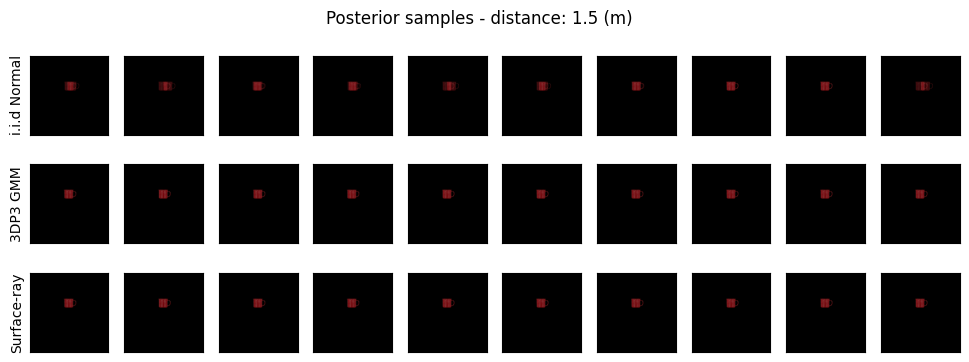

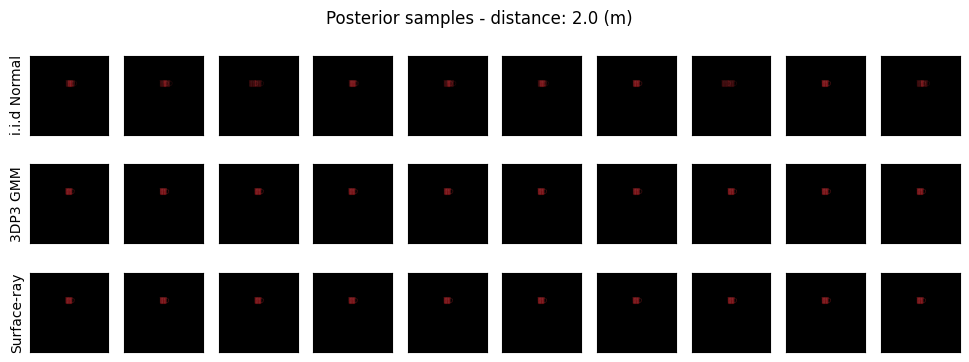

In [15]:
key = jax.random.PRNGKey(0)

apply_vec = jax.vmap(lambda pose, vertices: pose.apply(vertices), (0, None))
num_samples = 10
for dist_ind, distance in enumerate(distances):
    fig, axes = plt.subplots(len(models), num_samples, figsize=(num_samples+2, len(models)+1))
    fig.suptitle('Posterior samples - distance: ' + str(distance + cam_y_distance) + ' (m)', fontsize=12)
    
    point1 = jnp.array([dist_min,distance,0])
    point2 = jnp.array([dist_max,distance,0])
    alphas = jnp.linspace(0, 1, num_points)
    vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))
    linear_poses = vec_fun(point1, point2, alphas)

    rgbd_gt = render_rgbd_many(renderers[0], jnp.array([linear_poses[len(linear_poses)//2].apply(object_library.vertices)]), 
                                object_library.faces, jnp.tile(object_library.attributes, (1,1,1)))
    rgb_gt = rgbd_gt[0,...,:3]

    for model_ind, _ in enumerate(models):
        scores = model_scores[model_ind, dist_ind]

        samples = jax.random.categorical(key, scores, shape=(num_samples,)) 

        rgbd_im = render_rgbd_many(renderers[0], apply_vec(linear_poses[samples],jnp.array(object_library.vertices)), 
                                   object_library.faces, jnp.tile(object_library.attributes, (num_samples,1,1)))

        for i in range(len(samples)):
            axes[model_ind, i].imshow((rgbd_im[i,...,:3]+rgb_gt)/2)
            #axes[model_ind, i].axis('off')
            axes[model_ind, i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

        for ax, row in zip(axes[:,0], model_names):
            ax.set_ylabel(row, rotation=90)
            ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    # fig.tight_layout()

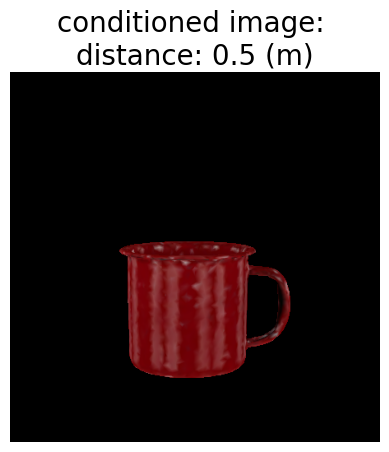

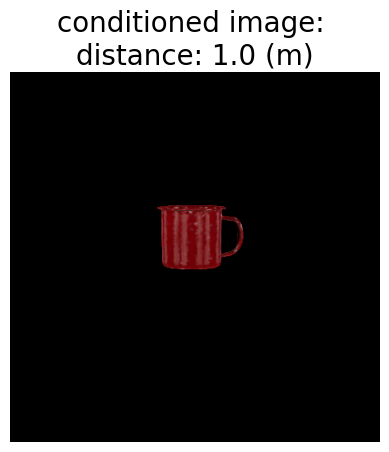

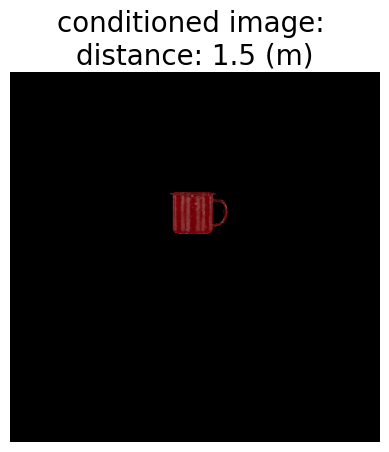

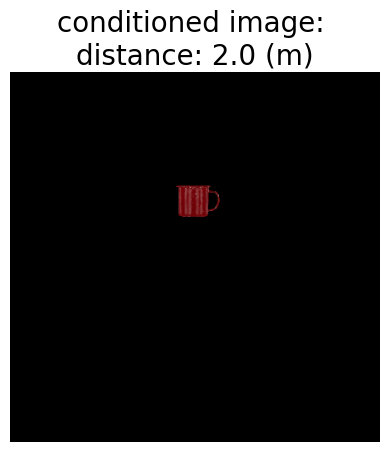

In [16]:
for dist_ind, distance in enumerate(distances):
    plt.figure()
    plt.title("conditioned image: \ndistance: " + str(distance + cam_y_distance) + ' (m)', fontsize=20)
    plt.imshow(gt_images[dist_ind])
    plt.axis('off')